In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

from sklearn.preprocessing import StandardScaler

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data(hourly=True)

Now, we will normalize the data.

In [4]:
# scaler = StandardScaler()
# train = scaler.fit_transform(train)
# test = scaler.transform(test)

# list(train.columns)

mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,prcp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2009-05-10 10:00:00,0.254668,-0.179754,0.234085,-0.975517,-0.724918,0.360180,0.342674,1.036122,0.780809,-0.146297,...,0,0,1,0,0,0,0,0,0,0
2014-12-25 20:00:00,-0.474882,-0.603607,-0.478673,-0.535035,0.073934,0.360180,-0.500869,0.660871,0.422196,-0.146297,...,0,0,0,0,0,0,0,0,0,1
2011-10-20 03:00:00,0.591383,1.303734,0.563051,2.052795,-2.785114,-3.466023,0.623855,-0.277256,0.780809,-0.146297,...,0,0,0,0,0,0,0,1,0,0
2007-06-18 02:00:00,1.208695,1.091808,1.275809,-0.094554,-0.514694,0.360180,1.139354,1.317561,-1.012255,-0.146297,...,0,0,0,1,0,0,0,0,0,0
2008-05-12 17:00:00,-0.082048,-0.232735,-0.094880,-0.479975,-1.397635,0.360180,0.061493,-1.215384,2.573874,-0.146297,...,0,0,1,0,0,0,0,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(8, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 456)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               58496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 59,537
Trainable params: 59,537
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 95077 samples, validate on 23770 samples
Epoch 1/10
95077/95077 [==============================] - 12s 124us/step - loss: 0.1161 - mean_absolute_error: 0.2552 - val_loss: 0.0593 - val_mean_absolute_error: 0.1808
Epoch 2/10
95077/95077 [==============================] - 12s 123us/step - loss: 0.0672 - mean_absolute_error: 0.1937 - val_loss: 0.0492 - val_mean_absolute_error: 0.1603
Epoch 3/10
95077/95077 [==============================] - 12s 126us/step - loss: 0.0583 - mean_absolute_error: 0.1795 - val_loss: 0.0504 - val_mean_absolute_error: 0.1661
Epoch 4/10
95077/95077 [==============================] - 12s 127us/step - loss: 0.0529 - mean_absolute_error: 0.1708 - val_loss: 0.0418 - val_mean_absolute_error: 0.1478
Epoch 5/10
95077/95077 [==============================] - 12s 128us/step - loss: 0.0494 - mean_absolute_error: 0.1640 - val_loss: 0.0426 - val_mean_absolute_error: 0.1540
Epoch 6/10
95077/95077 [==============================] - 12s 127us/step - loss: 0.0463 - mean_

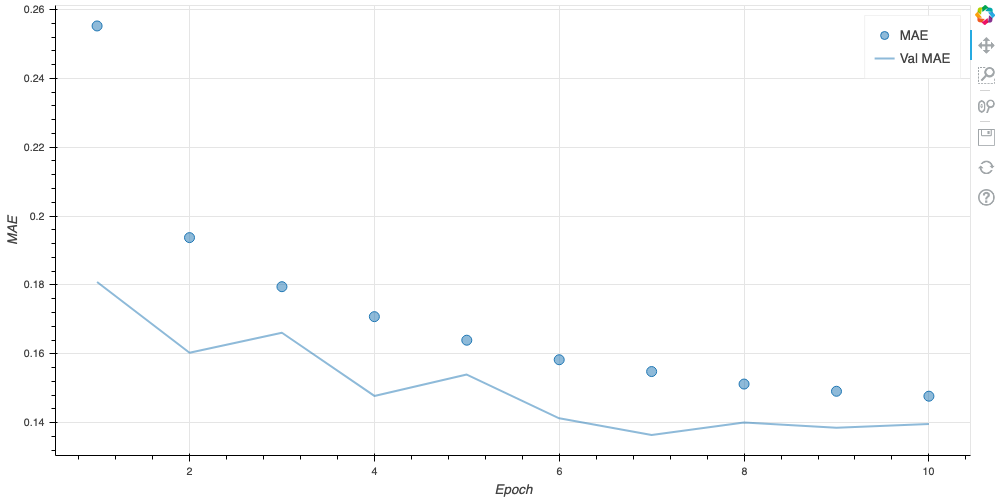

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

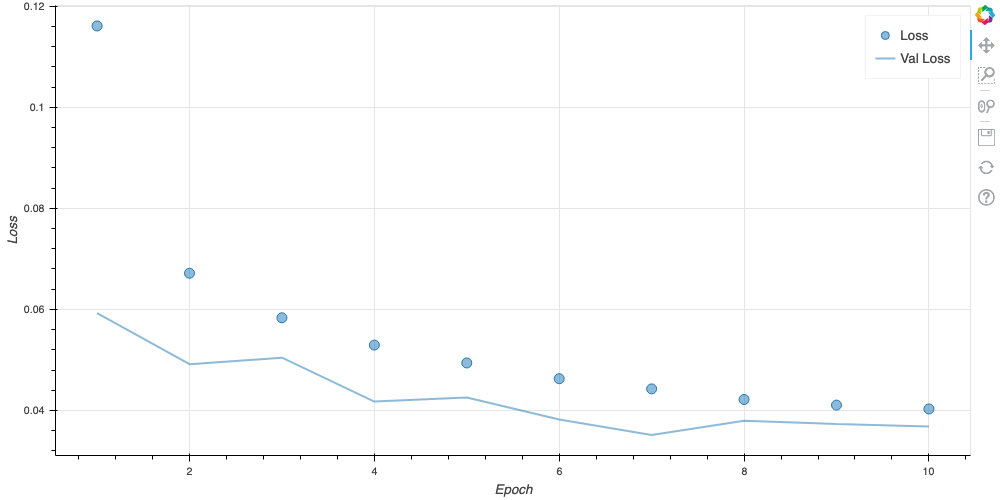

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  

In [19]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf_hourly(lookahead=1)
results = test.copy()
results['prediction'] = predictions
results = results.join(isolf, how='inner')
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 2353636.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 44.91 (5930/13205)


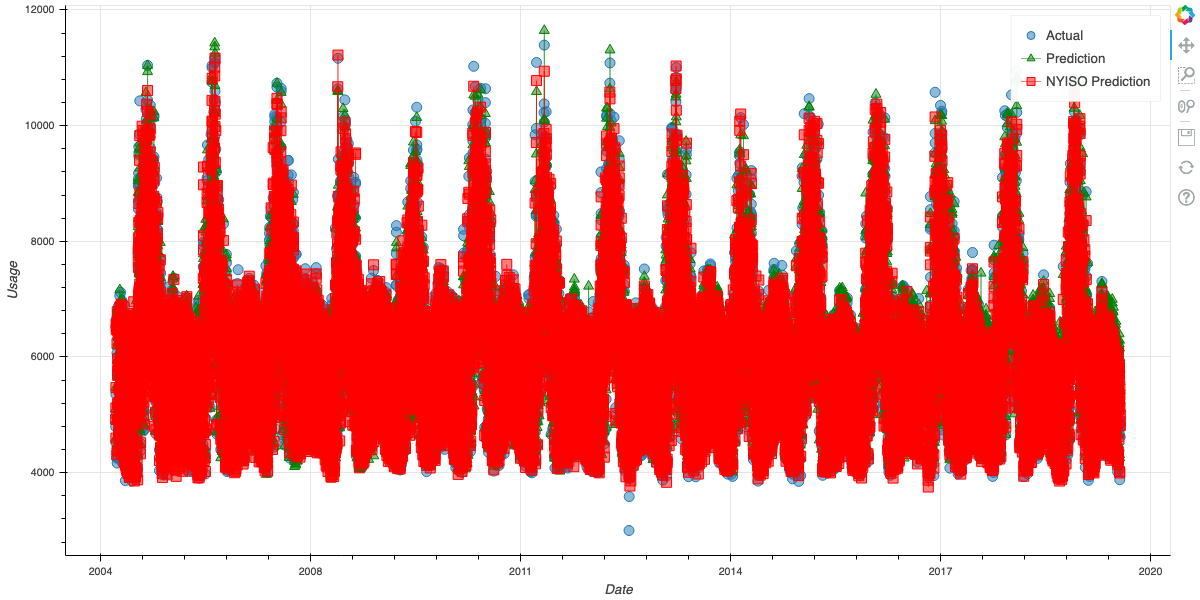

In [20]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [218]:
results

,target,t_max,t_avg,t_min,dwpt_max,dwpt_avg,dwpt_min,rh_max,rh_avg,rh_min,...,month_8,month_9,month_10,month_11,month_12,nyiso_prediction,prediction,date,prediction_error,nyiso_prediction_error
2006-07-02,6642.901365,-0.596664,-0.248241,0.103890,-1.102576,-1.468887,-1.485085,-1.998213,-1.108881,-0.164690,...,0,0,0,0,0,6699.208333,4906.000000,2006-07-02,-1736.901365,56.306968
2007-10-09,7144.031142,1.104569,0.767481,0.633141,1.053464,0.930228,0.793720,0.505874,0.552214,0.632148,...,0,0,1,0,0,7164.708333,6294.541016,2007-10-09,-849.490126,20.677191
2018-08-30,9287.070470,1.488718,1.713553,1.750448,1.450629,1.431616,1.340634,-0.306262,-0.341708,-0.231093,...,1,0,0,0,0,8962.333333,8579.840820,2018-08-30,-707.229649,-324.737136
2010-07-06,9799.167586,2.147259,2.090821,1.868059,1.166939,1.313008,1.295058,-1.118399,-1.208947,-1.094334,...,0,0,0,0,0,9400.166667,9151.425781,2010-07-06,-647.741805,-399.000920
2007-08-14,7365.939236,1.104569,1.214398,1.221197,0.429347,0.450405,0.474688,-1.930535,-1.475789,-1.160737,...,1,0,0,0,0,7382.583333,6787.571289,2007-08-14,-578.367947,16.644097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-12,6828.020962,0.775298,1.017058,1.280003,1.450629,1.609528,1.705243,1.385688,2.026520,2.624242,...,0,1,0,0,0,7506.916667,7548.595703,2018-09-12,720.574741,678.895704
2020-03-24,4818.006552,-0.541785,-0.712570,-0.778194,-0.762149,-0.498458,-0.117802,0.370518,0.232003,0.100923,...,0,0,0,0,0,5064.791667,5575.962891,2020-03-24,757.956339,246.785115
2016-08-05,7253.401034,1.214326,1.278244,1.280003,0.939988,1.091966,1.203905,-0.712331,-0.254984,0.034519,...,1,0,0,0,0,6965.416667,8108.680664,2016-08-05,855.279630,-287.984368
2017-06-10,5764.069097,1.378961,1.318873,1.044780,0.713036,0.682230,0.793720,-1.389111,-1.202275,-0.895125,...,0,0,0,0,0,5653.208333,6657.875000,2017-06-10,893.805903,-110.860764
